## OOI M2M and Altair Tutorial

Note: this was completed with gracious assistance from Friedrich Knuth (who has done this sort of thing many times over). Thank you!

This tutorial will demonstrate how to obtain Ocean Observatories Initiative (OOI) data using M2M (Machine to Machine), in json format, and visualize using Altair.

OOI: https://ooi-visualocean.whoi.edu/
M2M: https://oceanobservatories.org/ooi-m2m-interface/
Prophet: https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/
Altair: https://altair-viz.github.io/


In [76]:
import requests
import json
import re
import os
import altair as alt 
import pandas as pd
import datetime

### Part One: Loading OOI Data

#### Step 1: Enter API Credentials

If you do not have an account on the OOI data portal, navigate to: https://ooinet.oceanobservatories.org/ and create an account. Access your username and token through your user profile.

In [77]:
API_USERNAME = 'OOIAPI-C8PXRLK9NX8K2Y'
API_TOKEN = 'TEMP-TOKEN-MQSQUZIWB1C2M3'

#### Step 2: Enter Instrument Information

Through the OOI data team portal: https://ooi-visualocean.whoi.edu/ find a device you would like extract data from. For this example, the following device is used: https://ooi-visualocean.whoi.edu/instruments/view/GS01SUMO-SBD12-06-METBKA000

Enter device information as follows, and assemble a request URL for the device.

In [78]:
site = 'GS01SUMO'
node = 'SBD12'
instrument = '06-METBKA000'
method = 'recovered_host'
stream = 'metbk_hourly'
api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'

# create request URL
data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

#### Step 3: Indicate Date Range and Options

Enter the date range you are interested in examining. "Daily stats" and "monthly stats" on the OOI data team portal website are helpful tools for this. Use 'limit' to specify the number of json data points you would like to limit extraction to. 

In [114]:
# specify date range and options
params = {
    'beginDT':'2012-10-18T00:00:00.000Z',
    'endDT':'2018-10-27T00:00:00.000Z',
    'limit':'1000' #20000 is maximum limit
}

#### Step 4: Request Data from the OOI THREDDS server

Note, this may have a long runtime, depending on your date range and limit value.

In [115]:
r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))

#### Step 5: Convert to Pandas DataFrame

In this tutorial, we will examine the dataset in pandas dataframe format, which interfaces nicely with altair. Take a look at how the data is formatted and see which measruements are available.

In [158]:
data = r.json()
df = pd.DataFrame(data)
df.head(10)

met_mommflx_qc_executed  met_tempskn_qc_results  met_latnflx  \
0                       16                      28          NaN   
1                       16                      28          NaN   
2                       16                      28          NaN   
3                       16                      29     3.130428   
4                       16                      29     1.824751   
5                       16                      28          NaN   
6                       16                      29    53.053987   
7                       16                      29     5.405764   
8                       16                      28          NaN   
9                       16                      28          NaN   

   metbk_a_dcl_instrument_recovered-barometric_pressure  \
0                                        1019.437970      
1                                        1012.908769      
2                                        1021.289828      
3                                        1014.711752      
4                                         993.888611      
5                                         981.115775      
6                                         998.821500      
7                                        1012.268856      
8                                        1013.465611      
9                                        1005.399536      

   velpt_ab_dcl_instrument_recovered-northward_velocity  met_rainflx  \
0                                           0.184762             NaN   
1                                           0.066933             NaN   
2                                           0.051749             NaN   
3                                          -0.036437        0.000000   
4                                           0.080318        0.011881   
5                                           0.282927             NaN   
6                                           0.086273        0.000000   
7                                          -0.080753        0.000230   
8                                          -0.018386             NaN   
9                                           0.152617             NaN   

   met_netlirr_qc_executed  met_stablty  \
0                       29          NaN   
1                       29          NaN   
2                       29          NaN   
3                       29    -0.002028   
4                       29     0.001075   
5                       29          NaN   
6                       29    -0.020008   
7                       29     0.011808   
8                       29          NaN   
9                       29          NaN   

   metbk_a_dcl_instrument_recovered-relative_humidity  met_heatflx_qc_results  \
0                                          94.325026                       16   
1                                          96.977867                       16   
2                                          85.810276                       16   
3                                          97.443737                       16   
4                                          96.866591                       16   
5                                          92.209193                       16   
6                                          83.744296                       16   
7                                          93.442958                       16   
8                                          94.265369                       16   
9                                          96.739855                       16   

   ...  met_sensflx_qc_executed  met_sphum2m_qc_executed  \
0  ...                       16                       29   
1  ...                       16                       29   
2  ...                       16                       29   
3  ...                       16                       29   
4  ...                       16                       29   
5  ...                       16                       29   
6  ...                       16     

Pro tip: navigate to the OOI data team portal for a handy list of measurement variable names: https://ooi-visualocean.whoi.edu/streams/view/metbk_hourly

#### Step 6: Change Time Format

We need to manually convert ntp seconds to date time for visualization in altair.

In [119]:
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

df['met_timeflx'] = df['met_timeflx'].apply(ntp_seconds_to_datetime)

### Part Two: Altair

Now we'll demonstrate some of altair's capabilities. For this section, we will focus on irradiance data measured by an OOI pyranometer: https://oceanobservatories.org/data-product/netsirr/ and wind data measured by Direct Covariance Flux System observations: https://oceanobservatories.org/data-product/wind10m/.

#### Example 1: Simple Timeseries Plot

Examining irradiance over time.

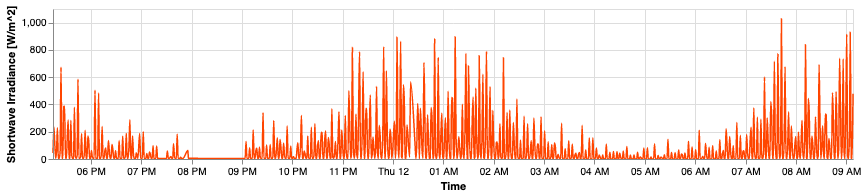

In [194]:
alt.Chart(df).mark_line(
    color='orangered',
    interpolate='monotone',
    strokeWidth=1.5
).encode(
    alt.X('met_timeflx:T', axis = alt.Axis(title='Time')),
    alt.Y('met_netsirr_hourly:Q', axis = alt.Axis(title='Shortwave Irradiance [W/m^2]'))
).properties(
    width=800,
    height=150
)

#### Example 2: Scatter Plot

Examinine correlation of irradiance and wind velocity. 

//miniconda3/envs/DataAccess/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


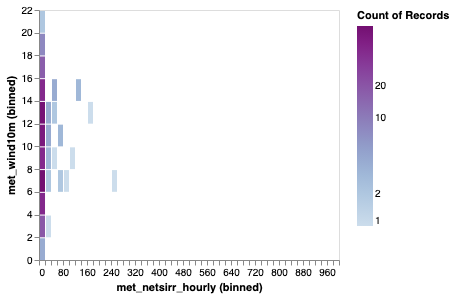

In [214]:
df['met_netsirr_hourly'][df['met_netsirr_hourly'] < 0] = 0 #set negative irradiance values to zero

alt.Chart(df).mark_bar().encode(
    alt.X('met_netsirr_hourly',bin=alt.BinParams(maxbins=100),scale=alt.Scale(domain=[0, 1000])),
    alt.Y('met_wind10m',bin=alt.BinParams(maxbins=10)),
    alt.Color('count()', scale=alt.Scale(scheme='bluepurple',type='log'))
).properties(
    width=300,
    height=250
)

met_mommflx_qc_executed  met_tempskn_qc_results  met_latnflx  \
0                         16                      28          NaN   
1                         16                      28          NaN   
2                         16                      28          NaN   
3                         16                      29     3.130428   
4                         16                      29     1.824751   
..                       ...                     ...          ...   
814                       16                      28          NaN   
815                       16                      28          NaN   
816                       16                      29    57.982141   
817                       16                      29    28.007881   
818                       16                      28          NaN   

     metbk_a_dcl_instrument_recovered-barometric_pressure  \
0                                          1019.437970      
1                                          1012.908769      
2                                          1021.289828      
3                                          1014.711752      
4                                           993.888611      
..                                                 ...      
814                                         995.498574      
815                                         994.135202      
816                                         999.555878      
817                                        1000.933775      
818                                        1012.320007      

     velpt_ab_dcl_instrument_recovered-northward_velocity  met_rainflx  \
0                                             0.184762             NaN   
1                                             0.066933             NaN   
2                                             0.051749             NaN   
3                                            -0.036437        0.000000   
4                                             0.080318        0.011881   
..                                                 ...             ...   
814                                           0.171893             NaN   
815                                           0.375764             NaN   
816                                           0.110840        0.102329   
817                                           0.118730        0.000000   
818                                           0.286140             NaN   

     met_netlirr_qc_executed  met_stablty  \
0                         29          NaN   
1                         29          NaN   
2                         29          NaN   
3                         29    -0.002028   
4                         29     0.001075   
..                       ...          ...   
814                       29          NaN   
815                       29          NaN   
816                       29    -0.007545   
817                       29    -0.199379   
818                       29          NaN   

     metbk_a_dcl_instrument_recovered-relative_humidity  \
0                                            94.325026    
1                                            96.977867    
2                                            85.810276    
3                                            97.443737    
4                                            96.866591    
..                                                 ...    
814                                          77.311698    
815                                          74.126372    
816                                          85.091201    
817                                          84.555247    
818                                          69.975998    

     met_heatflx_qc_results  ...  met_sensflx_qc_executed  \
0                        16  ...                       16   
1                        16  ...                       16   
2                        16  ...                       16   
3                        16  ...                       16   

In [72]:
data[0]['']

3633296698.972

In [67]:
data['met_timeflx']

3633296698.972

In [70]:
ntp_seconds_to_datetime(data[0]['met_timeflx'])

datetime.datetime(2015, 2, 19, 1, 4, 58)

#### Step 4: Request Data
##### IMPORTANT: only do this once!

Request data from the OOI THREDDS server. The first URL in the allURLs index points to the THREDDS server, which allows for programmatic data access, without downloading the entire dataset. Once you have this URL, you do not need to submit another request. 

Copy the URL from the output and paste it directly into your code. Comment out code to request data from the THREDDS server, as you no longer need to submit another request (unless you would like to change to a different device).

In [30]:
# #obtain url, then comment out
# r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
# data = r.json()
# url = data['allURLs'][0]
# url

#copy paste url here
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/catalog.html'

#### Step 5: Load NC Files

Use the following code to download all available .nc files from the directory. 

In [34]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/deployment0003_GS01SUMO-RID16-04-VELPTA000-recovered_host-velpt_ab_dcl_instrument_recovered_20161125T011556-20161212T143059.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/deployment0002_GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly_20151214T205007.614000-20161212T073021.525000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/deployment0002_GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20151214T202007.614000-20161212T075726.340000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/deployment0002_

In [35]:
# sort METBKA and VELPTA instruments
selected_datasets = []
for d in datasets:
    if 'VELPT' in d:
        pass
    else:
        selected_datasets.append(d)
selected_datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/deployment0002_GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly_20151214T205007.614000-20161212T073021.525000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/deployment0002_GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20151214T202007.614000-20161212T075726.340000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/deployment0001_GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly_20150318T003043.533000-20151227T113000.506000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tmaxd@uw.edu/20190828T191148083Z-GS01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/deployment0001_GS01SUM

In [38]:
# # load into xarray dataset
# ds = xr.open_mfdataset(selected_datasets)
# # ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
# # ds = ds.chunk({'time': 100}) # Used for optimization
# # ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
# ds

In [42]:
subset = [selected_datasets[0], selected_datasets[2]]

In [45]:
ds = xr.open_dataset(selected_datasets[0])
ds

<xarray.Dataset>
Dimensions:                  (obs: 8707)
Coordinates:
  * obs                      (obs) int32 0 1 2 3 4 ... 8702 8703 8704 8705 8706
    time                     (obs) datetime64[ns] ...
    lat                      (obs) float64 ...
    lon                      (obs) float64 ...
Data variables:
    met_timeflx              (obs) datetime64[ns] ...
    deployment               (obs) int32 ...
    met_rainrte              (obs) float64 ...
    met_buoyfls              (obs) float64 ...
    met_buoyflx              (obs) float64 ...
    met_frshflx              (obs) float64 ...
    met_heatflx              (obs) float64 ...
    met_latnflx              (obs) float64 ...
    met_mommflx              (obs) float64 ...
    met_netlirr              (obs) float64 ...
    met_rainflx              (obs) float64 ...
    met_sensflx              (obs) float64 ...
    met_sphum2m              (obs) float64 ...
    met_stablty              (obs) float64 ...
    met_tempa2m       

In [46]:
ds = xr.open_mfdataset(subset)

In [47]:
ds

<xarray.Dataset>
Dimensions:                  (obs: 14032)
Coordinates:
  * obs                      (obs) int64 0 1 2 3 4 ... 5320 5321 5322 5323 5324
    time                     (obs) datetime64[ns] dask.array<shape=(14032,), chunksize=(8707,)>
    lat                      (obs) float64 dask.array<shape=(14032,), chunksize=(8707,)>
    lon                      (obs) float64 dask.array<shape=(14032,), chunksize=(8707,)>
Data variables:
    met_timeflx              (obs) datetime64[ns] dask.array<shape=(14032,), chunksize=(8707,)>
    deployment               (obs) int32 dask.array<shape=(14032,), chunksize=(8707,)>
    met_rainrte              (obs) float64 dask.array<shape=(14032,), chunksize=(8707,)>
    met_buoyfls              (obs) float64 dask.array<shape=(14032,), chunksize=(8707,)>
    met_buoyflx              (obs) float64 dask.array<shape=(14032,), chunksize=(8707,)>
    met_frshflx              (obs) float64 dask.array<shape=(14032,), chunksize=(8707,)>
    met_heatflx    